In [1]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error, r2_score
from sksurv.metrics import concordance_index_censored as ci_scikit
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

# to change path when new data is extracted
# Note that there are different pipelines for prediction vs training/validation models
# Hence, need to extract twice. Make sure the data sets correspond to the same run!!
unbal_jobid="unbalanced_extracted/job_2021072714092960072813_homo_secureboost"  # change this to update output from FL model best = 2021072714092960072813
unbal_jobid_sbt_predict="unbalanced_extracted/job_2021072714182624960816_homo_secureboost"  # best = 2021072714182624960816

# top FATE balanced results
bal_jobid="balanced_extracted/job_202108050733324345917_homo_secureboost"
bal_jobid_sbt_predict="balanced_extracted/job_2021080507425414362310_homo_secureboost"

# top dc_federated results
dc_jobid = "01_08_2021_025908_combined"
no_aggregation = str(4)  # xth aggregation from which to take the final prediction

# only for FATE. Note that this does not necessarily need to be in sequence, since engine ID is provided
party_A="_0_guest_1111_output_data"
party_B="_0_host_2222_output_data"
party_C="_0_host_3333_output_data"

full_path="C:/Users/chanzl_thinkpad/Dropbox/Imperial/Individual Project/NASA/survival-analysis-nasa/"
central_test_results="C:/Users/chanzl_thinkpad/Dropbox/Imperial/Individual Project/NASA/survival-analysis-nasa/graphing.csv"
dc_path = "C:/Users/chanzl_thinkpad/Desktop/FATE-Ubuntu/dc_extracted/"
filename = "data.csv"

In [2]:
# read dc train data
df_A_nn_train=pd.read_csv(os.path.join(dc_path, dc_jobid, no_aggregation + "_yhat_train_worker_A.csv"))
df_B_nn_train=pd.read_csv(os.path.join(dc_path, dc_jobid, no_aggregation + "_yhat_train_worker_B.csv"))
df_C_nn_train=pd.read_csv(os.path.join(dc_path, dc_jobid, no_aggregation + "_yhat_train_worker_C.csv"))

# read dc test data
df_A_nn_test=pd.read_csv(os.path.join(dc_path, dc_jobid, no_aggregation + "_yhat_test_worker_A.csv"))
df_B_nn_test=pd.read_csv(os.path.join(dc_path, dc_jobid, no_aggregation + "_yhat_test_worker_B.csv"))
df_C_nn_test=pd.read_csv(os.path.join(dc_path, dc_jobid, no_aggregation + "_yhat_test_worker_C.csv"))

In [3]:
# read FATE balanced train data
df_A_bal=pd.read_csv(os.path.join(bal_jobid+party_A, filename))
df_B_bal=pd.read_csv(os.path.join(bal_jobid+party_B, filename))
df_C_bal=pd.read_csv(os.path.join(bal_jobid+party_C, filename))

# read FATE balanced test data
df_A_sbt_predict_bal=pd.read_csv(os.path.join(bal_jobid_sbt_predict+party_A, filename))
df_B_sbt_predict_bal=pd.read_csv(os.path.join(bal_jobid_sbt_predict+party_B, filename))
df_C_sbt_predict_bal=pd.read_csv(os.path.join(bal_jobid_sbt_predict+party_C, filename))

In [4]:
# read FATE unbalanced train data
df_A=pd.read_csv(os.path.join(unbal_jobid+party_A, filename))
df_B=pd.read_csv(os.path.join(unbal_jobid+party_B, filename))
df_C=pd.read_csv(os.path.join(unbal_jobid+party_C, filename))

# read FATE unbalanced test data
df_A_sbt_predict=pd.read_csv(os.path.join(unbal_jobid_sbt_predict+party_A, filename))
df_B_sbt_predict=pd.read_csv(os.path.join(unbal_jobid_sbt_predict+party_B, filename))
df_C_sbt_predict=pd.read_csv(os.path.join(unbal_jobid_sbt_predict+party_C, filename))

graph_data=pd.read_csv(central_test_results)

test_clipped = pd.read_csv(full_path + 'Dataset/processed/test_clipped.csv')
train_clipped = pd.read_csv(full_path + 'Dataset/processed/train_clipped.csv')

test_trend = pd.read_csv(full_path + 'Dataset/processed/rul_FL_test_trended_cluster.csv')
train_trend = pd.read_csv(full_path + 'Dataset/processed/rul_FL_train_trended_cluster.csv')
list_results = pd.read_excel(full_path + 'results/saved_results_16-07-2021_100012.xlsx')

# Helper functions

In [5]:
def format_FL_output(df, type="others"):
    df['window num'] = 0
    df['unit num'] = 0
    if type == "train":
        df.loc[df['type'] == "train", "window num"] = df.id % 100
        df.loc[df['type'] == "validate", "window num"] = df.id % 100
        df.loc[df['type'] == "predict", "window num"] = df.id % 100000
        
        # retrieve unit num
        df.loc[df['type'] == "train", "unit num"] = (df['id'] - df['window num']) / 100
        df.loc[df['type'] == "validate", "unit num"] = (df['id'] - df['window num']) / 100
        df.loc[df['type'] == "predict", "unit num"] = (df['id'] - df['window num']) / 100000
    else:
        df["window num"] = df.id % 100000
        df["unit num"] = (df['id'] - df['window num']) / 100000
    
    df['unit num'] = df['unit num'].astype(int)
    df.rename(columns={'predict_result': 'y_hat'}, inplace=True)

In [6]:
# both df_temp and df_main must be aligned before using this function. this function DOES NOT map by engine ID...
def map_test_result(df_temp, df_main, L=20):
    interim_result = df_main.copy()
    interim_result['y_hat'] = 0
    count = 0
    for engine in interim_result['unit num'].unique():
        # get first and last index position of each set of engine
        first_idx = interim_result['unit num'].eq(engine).idxmax()
        last_idx = interim_result['unit num'].eq(engine+1).idxmax()-1
        if last_idx == -1:
            last_idx = len(interim_result)-1

        # populate RUL for middle cycles
        while (last_idx - first_idx) >= L-1:
            mid_idx = first_idx + L - 1
            interim_result.iat[mid_idx, -1] = df_temp.iloc[count]['y_hat']
            anchor_up = df_temp.iloc[count]['y_hat']
            anchor_down = df_temp.iloc[count]['y_hat']
            count += 1
            first_idx += L
            for offset in range(1, L):
                interim_result.iat[mid_idx-offset, -1] = anchor_up + 1
                anchor_up += 1

        # populate RUL for remaining cycles
        for offset in range(1, last_idx-mid_idx+1):
            interim_result.iat[mid_idx + offset, -1] = anchor_down - 1
            anchor_down -= 1

    return interim_result

In [7]:
def nasaScore(RUL_true, RUL_hat):
    d = RUL_hat - RUL_true
    score = 0
    for i in d:
        if i >= 0:
            score += np.math.exp(i / 13) - 1
        else:
            score += np.math.exp(- i / 10) - 1
    return score/len(RUL_true)  # should the score be averaged?

In [8]:
def make_graph(df, selected_unit_num):
    fig, axs = plt.subplots(int(len(selected_unit_num)/2), 2)
    models = ['RUL', 'NN (tuned trended)', 'RF (trended)', 'FL-GBDT (Unbal_Trended)', 'FL-NN (Unbal)', 'FL-GBDT (Bal_Trended)']
    i = -1
    for ax in axs.flatten():
        i += 1
        df_graph = df[df['unit num'] == selected_unit_num[i]]
        ax.set_title('Test engine ' + str(selected_unit_num[i]))
        for col in models:
            if col == 'RUL':
                ax.plot(df_graph['cycle'], df_graph[col], label=col, linestyle='dashed', linewidth=0.75)
            else:
                ax.plot(df_graph['cycle'], df_graph[col], label=col, linewidth=0.75)
    plt.xlabel('Cycles')
    plt.ylabel('RUL')
    plt.legend(fontsize=14) # using a size in points
    # plt.rcParams["figure.figsize"] = (200,30)  # width x height
    # plt.figure(figsize=(10,100))  # width x height
    plt.show()

In [9]:
def evaluate(model, df_result, label='test'):
    """ Evaluates model output on rmse, R2 and C-Index
    Args:
    model (string): name of model for documentation
    df_result (pandas.df): dataframe with the headers 'unit num', 'RUL', 'y_hat', 'breakdown'
    label (string): type of output (train or test)

    Returns:
    list: returns [model, label, rmse, ci_sk, variance]
    """

    y_true = df_result['RUL']
    y_hat = df_result['y_hat']
    df_result['breakdown'].replace(0, False, inplace=True)  # rsf only takes true or false
    df_result['breakdown'].replace(1, True, inplace=True)  # rsf only takes true or false

    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)

    # the concordance index (CI) is interested on the order of the predictions, not the predictions themselves
    # CI can only be measured between individual samples where a censoring or failure event occurred
    # https://medium.com/analytics-vidhya/concordance-index-72298c11eac7#:~:text=The%20concordance%20index%20or%20c,this%20definition%20mean%20in%20practice
    df_result_grouped = df_result.groupby('unit num').last()
    breakdown = df_result_grouped['breakdown']
    y_true = df_result_grouped['RUL']
    y_hat = df_result_grouped['y_hat']
    ci_sk = ci_scikit(breakdown, y_true, y_hat)[0]
    score = nasaScore(y_true, y_hat)  # score should be based on the last instance
    print('{} set RMSE:{:.2f}, Score:{:.2f}, CI(scikit):{:.4f}, R2:{:.2f}'.format(label, rmse, score, ci_sk, variance))
    result = [model, label, rmse, score, ci_sk, variance]
    return result

In [10]:
# to return value in last cycle for each engine
def return_final_value(df, column):
    # to show avg cycle at which event occurred
    final_value = []
    for i in range(1, 101):
        df_engine = df[df['unit num'] == i]
        value_at_last_row = df_engine.loc[df_engine.index[-1], column] 
        final_value.append(int(value_at_last_row))
    return final_value

In [11]:
# to map engine id back to dc_federated results
def map_engine_id(df_dest, df_answer, cluster):
    df_temp = df_answer[df_answer['cluster'] == cluster]
    df_temp.reset_index(inplace=True)
    df_dest['window num'] = df_temp['window num']
    df_dest['unit num'] = df_temp['unit num']

# Formatting federated output

In [12]:
format_FL_output(df_A, "train")
format_FL_output(df_B, "train")
format_FL_output(df_C, "train")

format_FL_output(df_A_bal, "train")
format_FL_output(df_B_bal, "train")
format_FL_output(df_C_bal, "train")

format_FL_output(df_A_sbt_predict)
format_FL_output(df_B_sbt_predict)
format_FL_output(df_C_sbt_predict)

format_FL_output(df_A_sbt_predict_bal)
format_FL_output(df_B_sbt_predict_bal)
format_FL_output(df_C_sbt_predict_bal)

# dc_federated results does not come with engine id, hence need to map it back
map_engine_id(df_A_nn_test, test_trend, 1)
map_engine_id(df_B_nn_test, test_trend, 2)
map_engine_id(df_C_nn_test, test_trend, 3)

In [13]:
# combine individual parties into one single file
df_master_FL = df_A.copy()
df_master_FL=df_master_FL.append(df_B)
df_master_FL=df_master_FL.append(df_C)

df_master_FL_sbt_predict = df_A_sbt_predict.copy()
df_master_FL_sbt_predict=df_master_FL_sbt_predict.append(df_B_sbt_predict)
df_master_FL_sbt_predict=df_master_FL_sbt_predict.append(df_C_sbt_predict)

df_master_FL_nn = df_A_nn_test.copy()
df_master_FL_nn = df_master_FL_nn.append(df_B_nn_test)
df_master_FL_nn = df_master_FL_nn.append(df_C_nn_test)

In [14]:
df_balanced_FL = df_A_bal.copy()
df_balanced_FL=df_balanced_FL.append(df_B_bal)
df_balanced_FL=df_balanced_FL.append(df_C_bal)

df_balanced_FL_sbt_predict = df_A_sbt_predict_bal.copy()
df_balanced_FL_sbt_predict=df_balanced_FL_sbt_predict.append(df_B_sbt_predict_bal)
df_balanced_FL_sbt_predict=df_balanced_FL_sbt_predict.append(df_C_sbt_predict_bal)

In [15]:
# sort as it is very important step to align results with results file!
df_master_FL.sort_values(['unit num', 'window num'], ascending=[True, True], inplace=True)
df_master_FL_sbt_predict.sort_values(['unit num', 'window num'], ascending=[True, True], inplace=True)

df_balanced_FL.sort_values(['unit num', 'window num'], ascending=[True, True], inplace=True)
df_balanced_FL_sbt_predict.sort_values(['unit num', 'window num'], ascending=[True, True], inplace=True)

df_master_FL_nn.sort_values(['unit num', 'window num'], ascending=[True, True], inplace=True)

# reset index
df_master_FL.reset_index(inplace=True)
df_master_FL_sbt_predict.reset_index(inplace=True)

df_balanced_FL.reset_index(inplace=True)
df_balanced_FL_sbt_predict.reset_index(inplace=True)

df_master_FL_nn.reset_index(inplace=True)

In [16]:
# df_master_FL.to_excel("TEST.xlsx")

# Adding back prediction back for graphing.csv

In [17]:
# adding back unbalanced FATE results
df_temp = test_trend.copy()
df_temp['y_hat']=df_master_FL_sbt_predict['y_hat']
GBDT_unbal_result_test = map_test_result(df_temp, test_clipped)

df_temp = train_trend.copy()
df_temp['y_hat']=df_master_FL['y_hat']
GBDT_unbal_result_train = map_test_result(df_temp, train_clipped)

graph_data['FL-GBDT (Unbal_Trended)'] = GBDT_unbal_result_test['y_hat']
# graph_data.head()

In [18]:
# adding back balanced FATE results
df_temp = test_trend.copy()
df_temp['y_hat']=df_balanced_FL_sbt_predict['y_hat']
GBDT_bal_result_test = map_test_result(df_temp, test_clipped)

df_temp = train_trend.copy()
df_temp['y_hat']=df_balanced_FL['y_hat']
GBDT_bal_result_train = map_test_result(df_temp, train_clipped)

graph_data['FL-GBDT (Bal_Trended)'] = GBDT_bal_result_test['y_hat']
# graph_data.head()

In [19]:
# adding back dc_federated results
df_temp = test_trend.copy()
df_temp['y_hat'] = df_master_FL_nn['0']
df_temp['y_hat'] = df_temp['y_hat']
NN_unbal_result = map_test_result(df_temp, test_clipped)
graph_data['FL-NN (Unbal)'] = NN_unbal_result['y_hat']

In [20]:
# calculate final cycle when failure occurs
graph_data['true_final_cycle'] = graph_data['cycle'] + graph_data['RUL']
graph_data['RF_trended_final_cycle'] = graph_data['cycle'] + graph_data['RF (trended)']

graph_data['FL_GBDT_unbal_final_cycle'] = graph_data['cycle'] + graph_data['FL-GBDT (Unbal_Trended)']
graph_data['FL_GBDT_bal_final_cycle'] = graph_data['cycle'] + graph_data['FL-GBDT (Bal_Trended)']

graph_data['FL_NN_unbal_final_cycle'] = graph_data['cycle'] + graph_data['FL-NN (Unbal)']

In [21]:
# save graph data
graph_data.to_excel("graphing.xlsx")

# Plotting output

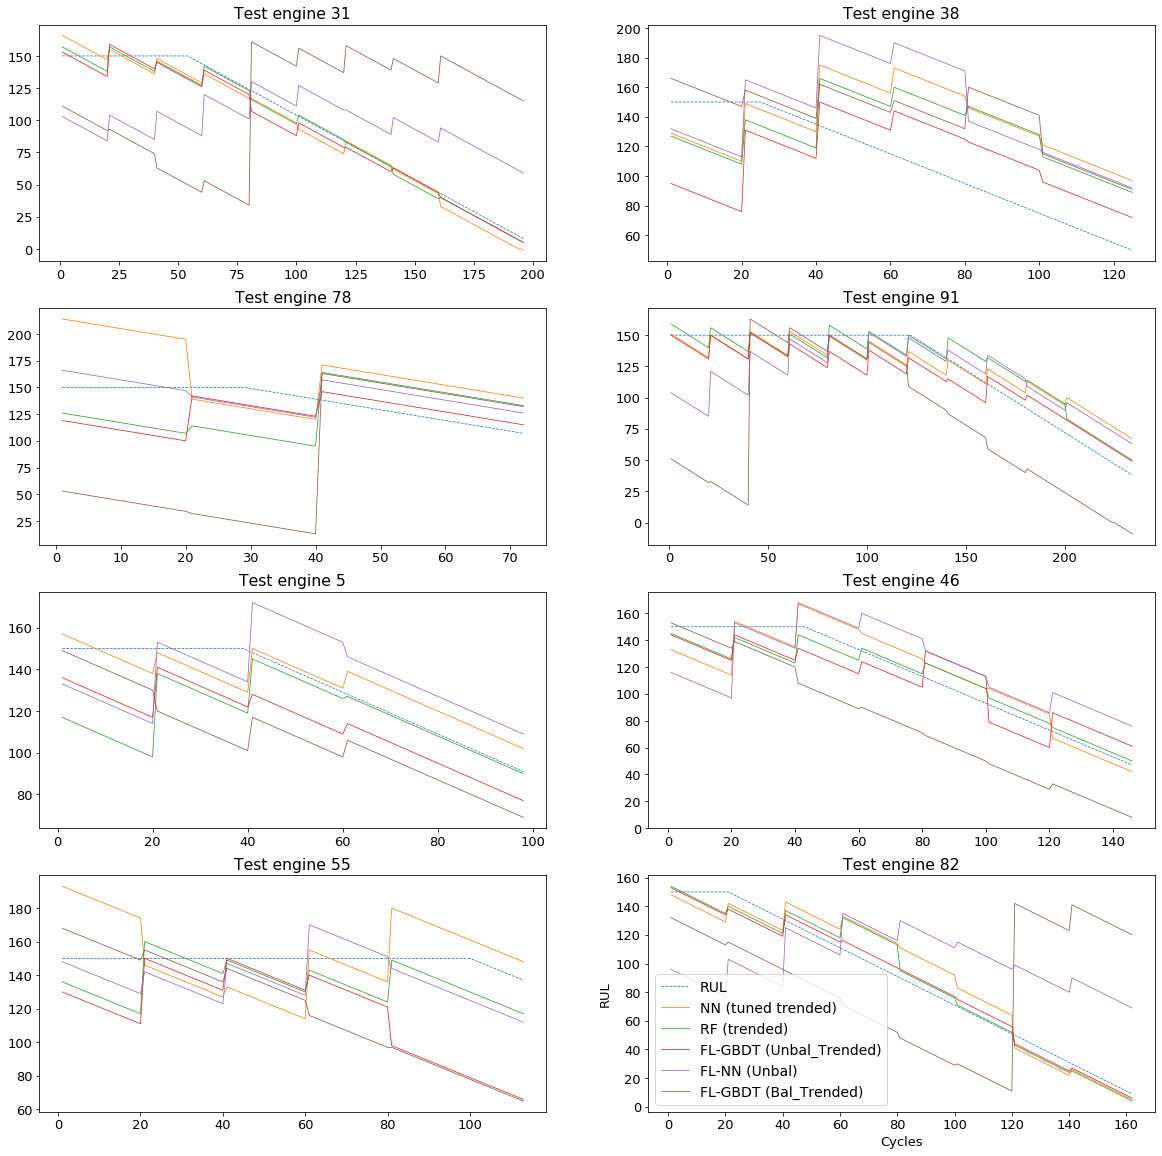

In [22]:
plt.rcParams["figure.figsize"] = (20,20)
plt.rcParams.update({'font.size': 13})
make_graph(graph_data, [31, 38, 78, 91, 5, 46, 55, 82])

In [23]:
ori_failure = return_final_value(graph_data, 'RUL')
rf_failure = return_final_value(graph_data, 'RF (trended)')
FL_GBDT_failure_unbal = return_final_value(graph_data, 'FL-GBDT (Unbal_Trended)')
FL_GBDT_failure_bal = return_final_value(graph_data, 'FL-GBDT (Bal_Trended)')
FL_nn_failure_unbal = return_final_value(graph_data, 'FL-NN (Unbal)')

In [24]:
final_cycle_at_failure = return_final_value(graph_data, 'true_final_cycle')
RF_cycle_at_failure = return_final_value(graph_data, 'RF_trended_final_cycle')
FL_GBDT_unbal_cycle_at_failure = return_final_value(graph_data, 'FL_GBDT_unbal_final_cycle')
FL_GBDT_bal_cycle_at_failure = return_final_value(graph_data, 'FL_GBDT_bal_final_cycle')
FL_NN_unbal_cycle_at_failure = return_final_value(graph_data, 'FL_NN_unbal_final_cycle')

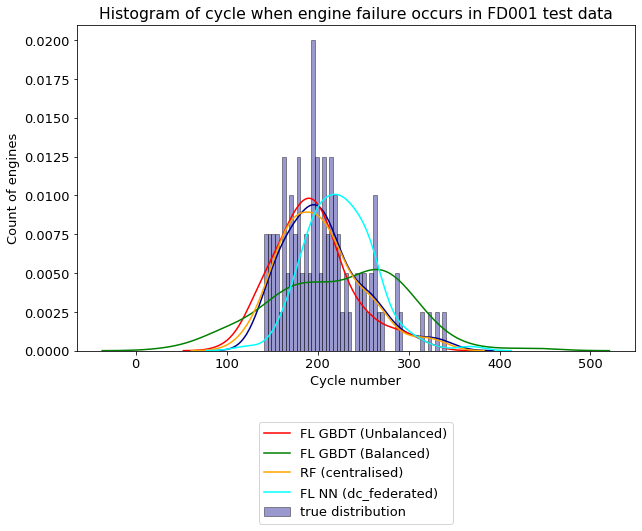

In [25]:
fig, ax = plt.subplots(figsize=(10, 6))  # width x height)
sns.distplot(final_cycle_at_failure, hist=True, kde=True, hist_kws={'edgecolor':'black'}, 
             label="true distribution", kde_kws={'linewidth': 1.5}, color='darkblue', bins=50)
sns.distplot(FL_GBDT_unbal_cycle_at_failure, hist=False, kde=True, hist_kws={'edgecolor':'black'}, 
             label="FL GBDT (Unbalanced)", kde_kws={'linewidth': 1.5},color='red', bins=50)
sns.distplot(FL_GBDT_bal_cycle_at_failure, hist=False, kde=True, hist_kws={'edgecolor':'green'}, 
             label="FL GBDT (Balanced)", kde_kws={'linewidth': 1.5},color='green', bins=50)
sns.distplot(RF_cycle_at_failure, hist=False, kde=True, hist_kws={'edgecolor':'black'}, 
             label="RF (centralised)", kde_kws={'linewidth': 1.5},color='orange', bins=50)
sns.distplot(FL_NN_unbal_cycle_at_failure, hist=False, kde=True, hist_kws={'edgecolor':'black'}, 
             label="FL NN (dc_federated)", kde_kws={'linewidth': 1.5},color='cyan', bins=50)
ax.set_title("Histogram of cycle when engine failure occurs in FD001 test data")
ax.set(xlabel="Cycle number", ylabel='Count of engines')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)
# ax.set_xlim(1,350)
plt.show()

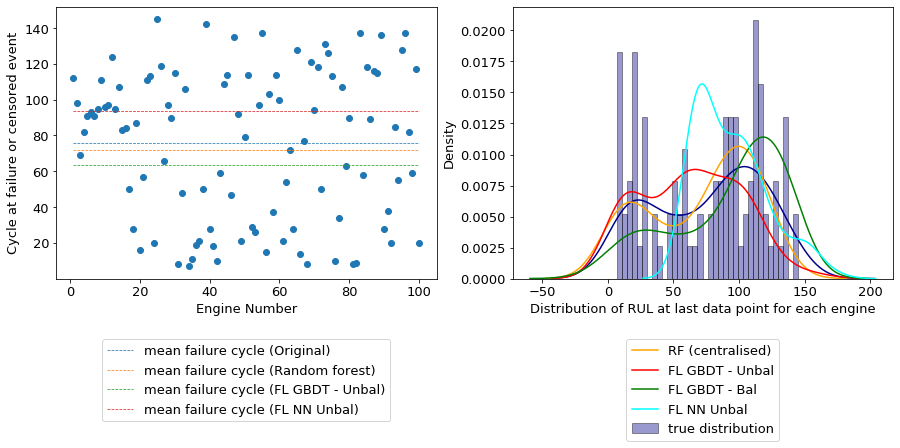

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))  # width x height
axes[0].scatter(range(1, 101), ori_failure, marker='o')

axes[0].plot(range(1, 101), [stats.describe(ori_failure)[2]]*100, linestyle='dashed', 
             linewidth = 0.75, label='mean failure cycle (Original)')
axes[0].plot(range(1, 101), [stats.describe(rf_failure)[2]]*100, linestyle='dashed', 
             linewidth = 0.75, label='mean failure cycle (Random forest)')
axes[0].plot(range(1, 101), [stats.describe(FL_GBDT_failure_unbal)[2]]*100, linestyle='dashed', 
             linewidth = 0.75, label='mean failure cycle (FL GBDT - Unbal)')
axes[0].plot(range(1, 101), [stats.describe(FL_nn_failure_unbal)[2]]*100, linestyle='dashed', 
             linewidth = 0.75, label='mean failure cycle (FL NN Unbal)')

axes[0].set_xlabel("Engine Number")
axes[0].set_ylabel("Cycle at failure or censored event")
axes[0].legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)

########################################################################################

ax = sns.distplot(ori_failure, hist=True, kde=True, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'}, label="true distribution",
             kde_kws={'linewidth': 1.5}, ax=axes[1])
ax = sns.distplot(rf_failure, hist=False, kde=True, 
             bins=int(180/5), color = 'orange', 
             hist_kws={'edgecolor':'black'}, label="RF (centralised)",
             kde_kws={'linewidth': 1.5}, ax=axes[1])
ax = sns.distplot(FL_GBDT_failure_unbal, hist=False, kde=True, 
             bins=int(180/5), color = 'red', 
             hist_kws={'edgecolor':'black'}, label="FL GBDT - Unbal",
             kde_kws={'linewidth': 1.5}, ax=axes[1])
ax = sns.distplot(FL_GBDT_failure_bal, hist=False, kde=True, 
             bins=int(180/5), color = 'green', 
             hist_kws={'edgecolor':'green'}, label="FL GBDT - Bal",
             kde_kws={'linewidth': 1.5}, ax=axes[1])
ax = sns.distplot(FL_nn_failure_unbal, hist=False, kde=True, 
             bins=int(180/5), color = 'cyan', 
             hist_kws={'edgecolor':'black'}, label="FL NN Unbal",
             kde_kws={'linewidth': 1.5}, ax=axes[1])

ax.set(xlabel="Distribution of RUL at last data point for each engine", ylabel='Density')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=1)

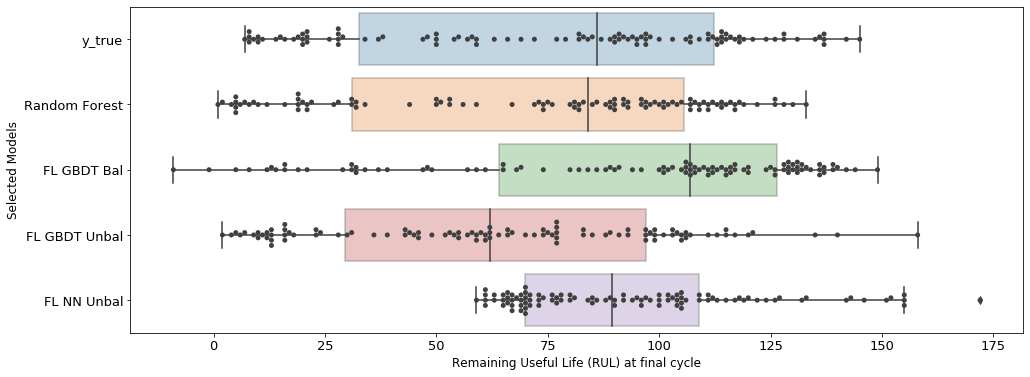

In [27]:
plt.figure(figsize=(16, 6))
dict_boxplot = {'y_true': ori_failure, 'Random Forest': rf_failure, 'FL GBDT Bal': FL_GBDT_failure_bal,
                'FL GBDT Unbal': FL_GBDT_failure_unbal, 'FL NN Unbal': FL_nn_failure_unbal} 

df_boxplot = pd.melt(pd.DataFrame(dict_boxplot))
df_boxplot.rename(columns={'variable': 'selected model', 'value': 'cycle'}, inplace=True)
ax = sns.boxplot(y="selected model", x="cycle", data=df_boxplot, boxprops=dict(alpha=.3))
ax = sns.swarmplot(y="selected model", x="cycle", data=df_boxplot, color=".25")
# ax.axes.set_title("Boxplot of RUL at final cycle - actual vs random forest vs federated model",fontsize=12)
_ = ax.set_ylabel("Selected Models",fontsize=12)
_ = ax.set_xlabel("Remaining Useful Life (RUL) at final cycle",fontsize=12)

# Calculating RMSE and add to total result

In [28]:
list_results.drop('timestamp', axis=1, inplace=True)

In [29]:
test_result = evaluate("FL-GBDT (Unbal)", GBDT_unbal_result_test, 'test')
test_temp = pd.DataFrame([test_result])
test_temp.columns=['model_name', "train_test", 'RMSE', 'Score', 'CI_SK', 'R2']
list_results=list_results.append(test_temp, ignore_index=True)
test_temp.head()

test set RMSE:23.36, Score:62.92, CI(scikit):0.1791, R2:0.59


,model_name,train_test,RMSE,Score,CI_SK,R2
0,FL-GBDT (Unbal),test,23.362231,62.921242,0.179088,0.58553


In [30]:
test_result = evaluate("FL-GBDT (Bal)", GBDT_bal_result_test, 'test')
test_temp = pd.DataFrame([test_result])
test_temp.columns=['model_name', "train_test", 'RMSE', 'Score', 'CI_SK', 'R2']
list_results=list_results.append(test_temp, ignore_index=True)
test_temp.head()

test set RMSE:59.63, Score:26219.45, CI(scikit):0.5509, R2:-1.70


,model_name,train_test,RMSE,Score,CI_SK,R2
0,FL-GBDT (Bal),test,59.628427,26219.44702,0.550906,-1.700049


In [31]:
train_result = evaluate("FL-GBDT (Unbal)", GBDT_unbal_result_train, 'train')
train_temp = pd.DataFrame([train_result])
train_temp.columns=['model_name', "train_test", 'RMSE', 'Score', 'CI_SK', 'R2']
list_results=list_results.append(train_temp, ignore_index=True)
train_temp.head()

train set RMSE:10.83, Score:1.01, CI(scikit):0.0221, R2:0.95


,model_name,train_test,RMSE,Score,CI_SK,R2
0,FL-GBDT (Unbal),train,10.830921,1.00984,0.022142,0.948322


In [32]:
test_result = evaluate('FL-NN (Unbal)', NN_unbal_result, 'test')
test_temp = pd.DataFrame([test_result])
test_temp.columns=['model_name', "train_test", 'RMSE', 'Score', 'CI_SK', 'R2']
list_results=list_results.append(test_temp, ignore_index=True)
test_temp.head()

test set RMSE:28.62, Score:20.14, CI(scikit):0.1797, R2:0.38


,model_name,train_test,RMSE,Score,CI_SK,R2
0,FL-NN (Unbal),test,28.622568,20.144191,0.179699,0.377869


In [33]:
list_results.sort_values(['train_test', 'RMSE'], ascending=[True, True], inplace=True)
list_results.reset_index(inplace=True, drop=True)
list_results.head(50)

,model_name,train_test,RMSE,Score,CI_SK,R2
0,RF (trended),test,16.626900,8.440800,0.168000,0.790100
1,NN (tuned trended),test,22.796900,65.236000,0.158700,0.605300
2,NN (tuned trended classification),test,23.271800,13.754900,0.158800,0.588700
3,FL-GBDT (Unbal),test,23.362231,62.921242,0.179088,0.585530
4,NN (tuned),test,24.765800,10.246900,0.164700,0.534200
5,RF (pre-tuned),test,27.576600,8.480900,0.174200,0.422500
6,RF (tuned),test,27.804400,9.701800,0.188100,0.412900
7,FL-NN (Unbal),test,28.622568,20.144191,0.179699,0.377869
8,Cox,test,31.807600,15.398300,0.186700,0.231700
9,rsf (pre-tuned),test,33.832200,13744.516700,0.290100,0.130800
